In [8]:
%load_ext autoreload
%autoreload 2
# pull in new changes to python modules without having to restart notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
from jsbsim_utils import Logger, trim, simulate, linearize, rootlocus, clean_tf
import control 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
all_data = dict()

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

## Ground Trimming 

In [3]:
ct = 0
temp = []
def cost_ground(fdm):
    # modify cost to also penalize throttle   
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    temp.append(fdm.get_property_catalog('fbz'))
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2  
        
op_ground, props, res = trim(
    aircraft='F-35B-2',
    ic={
          'ic/vt-fps': 0,
          'ic/psi-true-deg': 280,
          'ap/gear-enable': 1,
          'fcs/left-brake-cmd-norm': 1,
          'fcs/right-brake-cmd-norm': 1,
          'fcs/center-brake-cmd-norm': 1,
#         'ic/vt-fps': 0,
#         'gear/gear-cmd-norm': 1,
#         'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
#         'fcs/throttle-cmd-norm': 0,
#         'fcs/aileron-cmd-norm': 0,
#         'fcs/elevator-cmd-norm': 0,
#         'fcs/rudder-cmd-norm': 0,
#         'fcs/left-brake-cmd-norm': 1,
#         'fcs/right-brake-cmd-norm': 1,
#         'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 0.31],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
    #bounds=[[np.deg2rad(-40), np.deg2rad(40)], [0, 20]],
    cost=cost_ground,
)

print(res)
print(op_ground)
print(temp[0])
print(temp[-1])

data = dict()
data['res'] = res
data['op_ground'] = op_ground
data['fbz_initial'] = temp[0]
data['fbz_final'] = temp[-1]
all_data = dict()
all_data['groundTrim'] = data

 final_simplex: (array([[0.00752277, 3.11212156],
       [0.00748106, 3.11221532],
       [0.00754464, 3.11216313]]), array([4.51973002e-06, 8.14117197e-06, 1.67505423e-05]))
           fun: 4.519730024921744e-06
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 43
        status: 0
       success: True
             x: array([0.00752277, 3.11212156])
 final_simplex: (array([[0.00752277, 3.11212156],
       [0.00748106, 3.11221532],
       [0.00754464, 3.11216313]]), array([4.51973002e-06, 8.14117197e-06, 1.67505423e-05]))
           fun: 4.519730024921744e-06
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 43
        status: 0
       success: True
             x: array([0.00752277, 3.11212156])
{'ic/vt-fps': 0, 'ic/psi-true-deg': 280, 'ap/gear-enable': 1, 'fcs/left-brake-cmd-norm': 1, 'fcs/right-brake-cmd-norm': 1, 'fcs/center-brake-cmd-norm': 1, 'ic/theta-rad': 0.007522769802197068, 'ic/h-agl-ft': 3.11

In [7]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

In [ ]:
log_ground['position/h-agl-ft'].plot()
plt.grid(True)
plt.ylabel('ft, altitude')

In [ ]:
log_ground['attitude/theta-deg'].plot()
plt.grid(True)
plt.ylabel('deg, aircraft pitch')

## Hover Trimming

In [4]:
op_hover, props, res = trim(
    aircraft='F-35B-2',
    ic={  
          'ic/h-sl-ft': 650,
          'ic/vt-fps': 0,
          'ic/psi-true-deg': 280,
          'ap/gear-enable': 1,
#         'ic/h-agl-ft': 10,
#         'ic/vd-fps': 0,
#         'ic/vn-fps': 0*np.cos(np.deg2rad(280)),
#         'ic/ve-fps': 0*np.sin(np.deg2rad(280)),
#         'ic/theta-rad': 0,
#         'gear/gear-cmd-norm': 1,
#         'fcs/left-brake-cmd-norm': 0,
#         'fcs/right-brake-cmd-norm': 0,
#         'fcs/center-brake-cmd-norm': 0,
    },
    eq_constraints = [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        #lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        #lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        #lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
        'propulsion/engine[1]/pitch-angle-rad',
        'propulsion/engine[2]/pitch-angle-rad',
        'propulsion/engine[3]/pitch-angle-rad',
    ],
#     design_vector=[
#         'fcs/throttle-cmd-norm',
#         'fcs/elevator-cmd-norm',
#         'propulsion/engine/pitch-angle-rad',
#         'propulsion/engine[1]/pitch-angle-rad',
#         'propulsion/engine[2]/pitch-angle-rad',
#         'propulsion/engine[3]/pitch-angle-rad',
#     ],
    x0=[0.9, 0.5, np.deg2rad(90), np.deg2rad(90), np.deg2rad(90), np.deg2rad(90)],
    cost= lambda fdm: fdm['fcs/throttle-cmd-norm'],
    verbose=True,
    method='SLSQP',
    bounds=[[0, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)], 
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)

print(op_hover)
data1 = dict()
data1['res'] = res
data1['op_hover'] = op_hover
all_data['hoverTrim'] = data1

     fun: 0.9293618671566662
     jac: array([1., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.92936187, 0.71734941, 1.57079634, 1.57079635, 1.57079634,
       1.57079634])
constraint eq 9.185534277644791e-14
constraint eq -3.04751779367507e-11
constraint eq 2.551709053638221e-12
{'ic/h-sl-ft': 650, 'ic/vt-fps': 0, 'ic/psi-true-deg': 280, 'ap/gear-enable': 1, 'fcs/throttle-cmd-norm': 0.9293618671566662, 'fcs/elevator-cmd-norm': 0.7173494106040665, 'propulsion/engine/pitch-angle-rad': 1.5707963395774596, 'propulsion/engine[1]/pitch-angle-rad': 1.5707963455541043, 'propulsion/engine[2]/pitch-angle-rad': 1.5707963395774596, 'propulsion/engine[3]/pitch-angle-rad': 1.5707963384164711}


In [8]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=10,
    realtime=True)

In [ ]:
log_hover['position/h-agl-ft'].plot()
plt.grid(True)
plt.ylabel('ft, altitude')

In [ ]:
plt.subplot()
log_hover['propulsion/engine/thrust-lbs'].plot()
log_hover['propulsion/engine[1]/thrust-lbs'].plot()
log_hover['propulsion/engine[2]/thrust-lbs'].plot()
log_hover['propulsion/engine[3]/thrust-lbs'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('lbs, engine thrusts')
plt.show()

In [ ]:
plt.subplot()
log_hover['propulsion/engine/pitch-angle-rad'].plot()
log_hover['propulsion/engine[1]/pitch-angle-rad'].plot()
log_hover['propulsion/engine[2]/pitch-angle-rad'].plot()
log_hover['propulsion/engine[3]/pitch-angle-rad'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('deg, engine pitch angle')
plt.show()

In [18]:
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = 0
op_hover_auto['ic/phi-deg'] = 0
op_hover_auto['ic/h-agl-ft'] = 60

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 0
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 0
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 700

log_hover_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_hover_auto,
    tf=50,
    realtime=False)

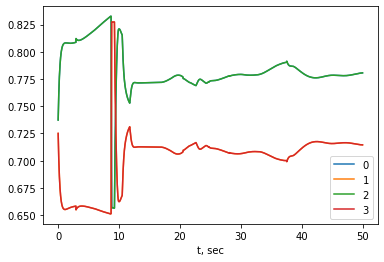

In [19]:
log_hover_auto['fcs/throttle-pos-norm'].plot(label='0')
log_hover_auto['fcs/throttle-pos-norm[1]'].plot(label='1')
log_hover_auto['fcs/throttle-pos-norm[2]'].plot(label='2')
log_hover_auto['fcs/throttle-pos-norm[3]'].plot(label='3')

plt.legend()

## Cruise Trimming

In [26]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*(lift/drag)**2 + 1e-3*(theta < 0) + 1e-1*throttle + 2e-1*delta**2 
        

op_cruise, prop, res = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 677,
        'ic/h-agl-ft': 38*1e3,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
        'propulsion/engine[1]/pitch-angle-rad': 0,
        'propulsion/engine[2]/pitch-angle-rad': 0,
        'propulsion/engine[3]/pitch-angle-rad': 0,
    },
#     design_vector=[
#         'fcs/throttle-cmd-norm',
#         'fcs/elevator-cmd-norm',
#         'fcs/rudder-cmd-norm',
#         'fcs/aileron-cmd-norm',
#         'ic/alpha-rad',
#         'ic/beta-rad',
#         'propulsion/engine/pitch-angle-rad',
#     ],
#     cost=cost_cruise,
    
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
    ],
    method='SLSQP',
    eq_constraints= [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
#     cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
    cost=cost_cruise,
    x0=[0.4, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]],
    tol=1e-12,
)
print(op_cruise)

data2 = dict()
data2['res'] = res
data2['op_cruise'] = op_cruise

all_data['cruiseTrim'] = data2

     fun: -0.0658821910745617
     jac: array([ 1.00028949e-01,  2.59588238e-01,  4.67710197e-06,  5.65499067e-06,
       -4.25912814e+00,  4.25211880e-02])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.16673315, 0.14031067, 0.00075739, 0.00022614, 0.02018319,
       0.00122505])
constraint eq 7.932099421736893e-12
constraint eq 7.108341693040643e-13
constraint eq -4.156675004196586e-12
constraint eq 6.37390942161292e-14
constraint eq -1.0761591720791191e-13
constraint eq -2.1582568283586667e-13
{'ic/gamma-rad': 0, 'ic/vt-fps': 677, 'ic/h-agl-ft': 38000.0, 'gear/gear-cmd-norm': 0, 'fcs/left-brake-cmd-norm': 0, 'fcs/right-brake-cmd-norm': 0, 'fcs/center-brake-cmd-norm': 0, 'propulsion/engine/pitch-angle-rad': 0, 'propulsion/engine[1]/pitch-angle-rad': 0, 'propulsion/engine[2]/pitch-angle-rad': 0, 'propulsion/engine[3]/pitch-angle-rad': 0, 'fcs/throttle-cmd-norm': 0.16673315207787176, 'fcs/elevator-cmd-

In [10]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=10,
    realtime=True)

In [ ]:
plt.subplot()
log_cruise['propulsion/engine/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[1]/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[2]/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[3]/pitch-angle-rad'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('lb, pounds')
plt.show()

In [ ]:
log_cruise['forces/fwx-aero-lbs'].plot()
plt.ylabel('lbs, drag')
plt.grid(True)

In [ ]:
log_cruise['forces/fwy-aero-lbs'].plot()
plt.grid(True)
plt.ylabel('lbs, side-force')

In [ ]:
log_cruise['forces/fwz-aero-lbs'].plot()
plt.grid(True)
plt.ylabel('lbs, lift')

In [ ]:
log_cruise['aero/alpha-deg'].plot()
plt.ylabel('deg, angle of attack')
plt.grid(True)

In [ ]:
log_cruise['fcs/elevator-pos-deg'].plot()
plt.grid(True)
plt.ylabel('deg, elevator angle')

In [ ]:
plt.subplot()
log_cruise['fcs/left-aileron-pos-deg'].plot()
log_cruise['fcs/right-aileron-pos-deg'].plot()
plt.grid(True)
plt.legend(['left aileron', 'right aileron'])
plt.ylabel("deg, aileron angle")
plt.show()

In [ ]:
log_cruise['fcs/rudder-pos-deg'].plot()
plt.grid(True)
plt.ylabel('deg, rudder angle')

In [ ]:
log_cruise['velocities/vt-fps'].plot()
plt.grid(True)
plt.ylabel("fps, velocity")

In [ ]:
del all_data['cruiseTrim']['res']['hess_inv']

In [ ]:
del all_data['hoverTrim']['res']['hess_inv']

In [ ]:
del all_data['cruiseTrim']['res']['message']
del all_data['groundTrim']['res']['message']
del all_data['hoverTrim']['res']['message']

In [ ]:
# encode numpy array for JSON serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# save all output as JSON file 
with open('jsbsim_opt.json', '+w') as jfile:
    json.dump(all_data, jfile, indent=4, cls=NumpyEncoder)

In [ ]:
result = log_cruise.to_json(orient="split")
parsed = json.loads(result)
with open('log_cruise.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)

In [ ]:
result = log_ground.to_json(orient="split")
parsed = json.loads(result)
with open('log_ground.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)

In [ ]:
result = log_hover.to_json(orient="split")
parsed = json.loads(result)
with open('log_hover.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)

## Transition 

In [5]:
def trim_transition(vt_fps, gamma_deg, accel_g):
    print('trimming @ Vt=', vt_fps, 'fps', 'gamma = ', gamma_deg, 'deg')
    
    def accel_gamma(fdm, accel_g, gamma_deg):
        gamma = np.deg2rad(gamma_deg)
        g = 32.2
        theta = fdm['attitude/theta-rad']
        C_nb = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        a_n = accel_g*g*np.array([np.cos(gamma), np.sin(gamma)])
        a_b = C_nb.T.dot(a_n)
        return a_b
    
    if vt_fps < 250:
        x0 = [0.9, 0, 0, 0, np.deg2rad(90), 
                            np.deg2rad(90),
                            np.deg2rad(90),
                            np.deg2rad(90),
              np.deg2rad(0), 0],
    elif vt_fps < 260:
        x0 = [0.9, 0, 0, 0, np.deg2rad(90), 
                            np.deg2rad(80),
                            np.deg2rad(90),
                            np.deg2rad(80),
              np.deg2rad(0), 0],
    elif vt_fps < 270:
        x0 = [0.9, 0, 0, 0, np.deg2rad(80), 
                            np.deg2rad(60),
                            np.deg2rad(80),
                            np.deg2rad(60),
              np.deg2rad(0), 0],
    elif vt_fps < 280:
        x0 = [0.9, 0, 0, 0, np.deg2rad(60), 
                            np.deg2rad(45),
                            np.deg2rad(60),
                            np.deg2rad(45),
              np.deg2rad(0), 0],
    elif vt_fps < 285:
        x0 = [0.9, 0, 0, 0, np.deg2rad(40), 
                            np.deg2rad(20),
                            np.deg2rad(40),
                            np.deg2rad(20),
              np.deg2rad(0), 0],
    elif vt_fps < 290:
        x0 = [0.9, 0, 0, 0, np.deg2rad(15), 
                            np.deg2rad(5),
                            np.deg2rad(15),
                            np.deg2rad(5),
              np.deg2rad(0), 0],
    elif vt_fps < 300:
        x0 = [0.9, 0, 0, 0, np.deg2rad(3), 
                            np.deg2rad(3),
                            np.deg2rad(3),
                            np.deg2rad(3),
              np.deg2rad(0), 0],
    else:
        x0 = [0.9, 0, 0, 0, np.deg2rad(0),
                            np.deg2rad(0),
                            np.deg2rad(0),
                            np.deg2rad(0),
              np.deg2rad(0), 0],

    op, props, res = trim(
        aircraft='F-35B-2',
        ic={
            'ic/h-sl-ft': 800,
            'ic/vt-fps': vt_fps,
            'ic/gamma-deg': gamma_deg,
            'ap/gear-enable': 1,
        },
        design_vector=[
            'fcs/throttle-cmd-norm',
            'fcs/elevator-cmd-norm',
            'fcs/rudder-cmd-norm',
            'fcs/aileron-cmd-norm',
            'propulsion/engine/pitch-angle-rad',
            'propulsion/engine[1]/pitch-angle-rad',
            'propulsion/engine[2]/pitch-angle-rad',
            'propulsion/engine[3]/pitch-angle-rad',
            'ic/alpha-rad',
            'ic/beta-rad',
        ],
        x0=x0,
        verbose=False,
        method='SLSQP',
        eq_constraints= [
            lambda fdm: fdm['accelerations/udot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[0],
            lambda fdm: fdm['accelerations/vdot-ft_sec2'],
            lambda fdm: fdm['accelerations/wdot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[1],
            lambda fdm: fdm['accelerations/pdot-rad_sec2'],
            lambda fdm: fdm['accelerations/qdot-rad_sec2'],
            lambda fdm: fdm['accelerations/rdot-rad_sec2'],
        ],
        cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
        bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1],
                [np.deg2rad(0), np.deg2rad(120)],
                [np.deg2rad(0), np.deg2rad(120)],
                [np.deg2rad(0), np.deg2rad(120)],
                [np.deg2rad(0), np.deg2rad(120)],
                [-0.1, 0.1], [-0.1, 0.1]],
        tol=1e-12)
    return op

ops_trim = [trim_transition(vt_fps=vt, gamma_deg=0, accel_g=0)
                  for vt in [10, 50, 100, 150, 200, 250, 300, 400, 500, 600]]
for op in ops_trim:
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('aileron', op['fcs/aileron-cmd-norm'])
    print('rudder', op['fcs/rudder-cmd-norm'])
    print('throttle', op['fcs/throttle-cmd-norm'])

trimming @ Vt= 10 fps gamma =  0 deg
trimming @ Vt= 50 fps gamma =  0 deg
trimming @ Vt= 100 fps gamma =  0 deg
trimming @ Vt= 150 fps gamma =  0 deg
trimming @ Vt= 200 fps gamma =  0 deg
trimming @ Vt= 250 fps gamma =  0 deg
trimming @ Vt= 300 fps gamma =  0 deg
trimming @ Vt= 400 fps gamma =  0 deg
trimming @ Vt= 500 fps gamma =  0 deg
trimming @ Vt= 600 fps gamma =  0 deg

vt fps 10
theta deg 5.729577792218203
elevator 0.6710420656064066
aileron 2.2693378436793652e-05
rudder 5.06222364686447e-07
throttle 0.9257660328032375

vt fps 50
theta deg 5.729577951308233
elevator 0.9999999999999996
aileron 9.463146684658394e-05
rudder -0.0008565431940129579
throttle 0.8893793793809612

vt fps 100
theta deg 1.7103079143637894
elevator 1.0
aileron 0.0004493619743805558
rudder 0.001232625279854894
throttle 0.8421432204783876

vt fps 150
theta deg 5.729577951308107
elevator 0.855137465923621
aileron 0.00044018824011450347
rudder 0.0017751956474354343
throttle 0.6977257471262603

vt fps 200
theta 

In [6]:
ops_transition = [trim_transition(vt_fps=vt, gamma_deg=10, accel_g=0.1)
                  for vt in [10, 50, 100, 150, 200, 250, 300, 400, 500, 600]]

ops_transition_auto = []
for op in ops_transition:
    op = dict(op)
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('aileron', op['fcs/aileron-cmd-norm'])
    print('rudder', op['fcs/rudder-cmd-norm'])
    print('throttle', op['fcs/throttle-cmd-norm'])
    op['ap/roll-enable'] = 1
    op['ap/pitch-enable'] = 1
    op['ap/yaw-enable'] = 1
    op['ap/h-enable'] = 0
    op['ap/h-sl-cmd-ft'] = 1000
    ops_transition_auto.append(op)

trimming @ Vt= 10 fps gamma =  10 deg
trimming @ Vt= 50 fps gamma =  10 deg
trimming @ Vt= 100 fps gamma =  10 deg
trimming @ Vt= 150 fps gamma =  10 deg
trimming @ Vt= 200 fps gamma =  10 deg
trimming @ Vt= 250 fps gamma =  10 deg
trimming @ Vt= 300 fps gamma =  10 deg
trimming @ Vt= 400 fps gamma =  10 deg
trimming @ Vt= 500 fps gamma =  10 deg
trimming @ Vt= 600 fps gamma =  10 deg

vt fps 10
theta deg 4.270422048691768
elevator 0.5770666565804813
aileron -2.0483140179548457e-06
rudder 5.270211927688648e-07
throttle 0.9295032561066235

vt fps 50
theta deg 15.729577951308233
elevator 0.8379113346312043
aileron -0.00038430705630779883
rudder 0.00020537496168948667
throttle 0.9046795159419647

vt fps 100
theta deg 15.729537163773182
elevator 1.0
aileron -0.0008069173095788827
rudder 0.0019449260578031959
throttle 0.8320856534400345

vt fps 150
theta deg 15.729577951308233
elevator 0.7887419599001066
aileron 0.0003810742539728812
rudder 0.0016804242513083077
throttle 0.7565741993470452


In [ ]:
log_transition_auto = []
for op in ops_transition_auto:
    log = simulate(
        aircraft='F-35B-2',
        op_0=op,
        tf=10,
        realtime=False)
    log_transition_auto.append(log)

## Auto takeoff 

In [ ]:
log_takeoff_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    op_list=[('hover', op_hover_auto, lambda fdm: fdm.get_sim_time() > 1),
             ('10 fps', ops_transition_auto[0], lambda fdm: fdm.get_sim_time() > 10),
             ('50 fps', ops_transition_auto[1], lambda fdm: fdm['velocities/vt-fps'] > 50),
             ('100 fps', ops_transition_auto[2], lambda fdm: fdm['velocities/vt-fps'] > 100),
             ('150 fps', ops_transition_auto[3], lambda fdm: fdm['velocities/vt-fps'] > 150),
             ('200 fps', ops_transition_auto[4], lambda fdm: fdm['velocities/vt-fps'] > 200),
             ('250 fps', ops_transition_auto[5], lambda fdm: fdm['velocities/vt-fps'] > 250),
             ('300 fps', ops_transition_auto[6], lambda fdm: fdm['velocities/vt-fps'] > 300),
             ('400 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 400),
             ('500 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 500),
             ('600 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 600),
    ],
    tf=120,
    realtime=True, verbose=True)

# Controller Design

## Pitch

In [9]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/q-rad_sec'],
    states_deriv = ['accelerations/qdot-rad_sec2'],
    inputs=['fcs/elevator-cmd-norm'],
    outputs=['ic/q-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
rad2deg = 180/np.pi
G_elev_to_pitch = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_elev_to_pitch

0 states have been removed from the model


TransferFunction(array([41.59673593]), array([1., 0., 0.]))

C:\Users\Tomo\anaconda3\lib\site-packages\control\margins.py:322: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\Tomo\anaconda3\lib\site-packages\control\margins.py:323: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]


(inf, 152.450666342585, nan, 2.0395277866824415)

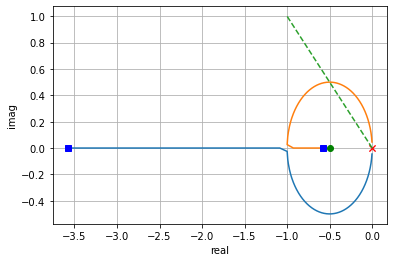

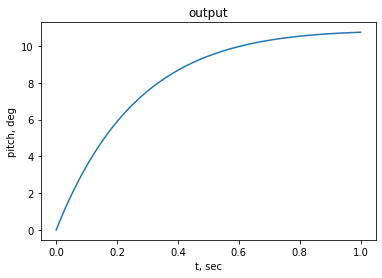

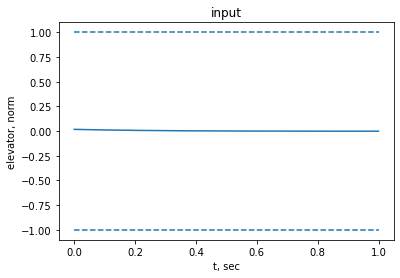

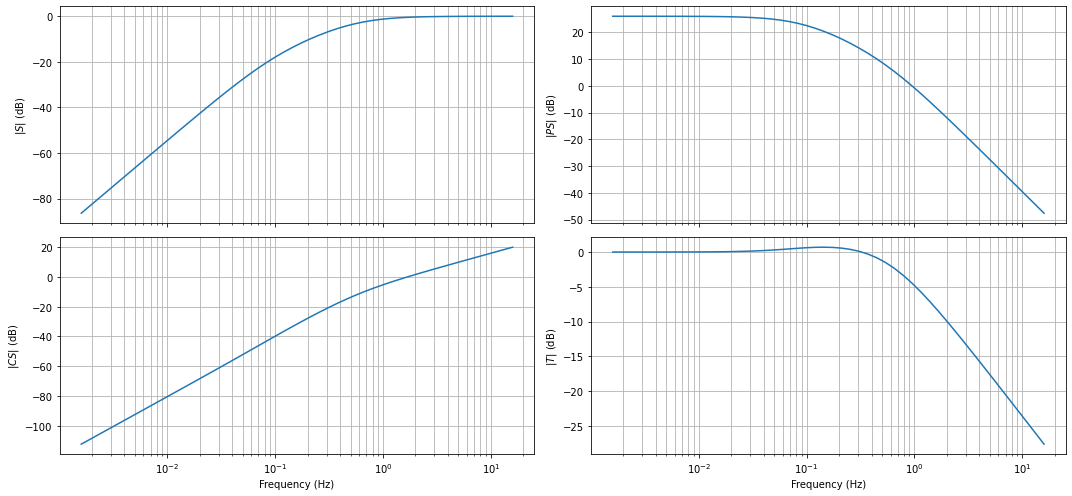

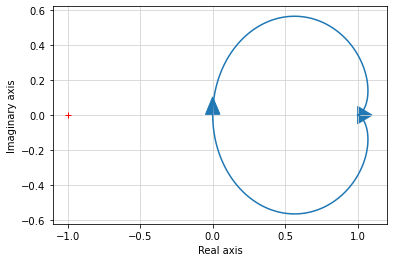

In [13]:
H_elev_to_pitch = 0.05*(s/0.5+1)

plt.figure()
rootlocus(G_elev_to_pitch*H_elev_to_pitch)
plt.plot([0, -1], [0, 1], '--')

Gc_elev_to_pitch = G_elev_to_pitch*H_elev_to_pitch/(1 + G_elev_to_pitch*H_elev_to_pitch)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_elev_to_pitch, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.ylabel('pitch, deg')
plt.xlabel('t, sec')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_elev_to_pitch, T=t, U=e)
plt.plot(t, u)
plt.hlines([-1, 1], t[0], t[-1], linestyles='dashed')
plt.title('input')
plt.ylabel('elevator, norm')
plt.xlabel('t, sec')

plt.figure(figsize=(15, 7))
control.gangof4(G_elev_to_pitch, H_elev_to_pitch, Hz=True, dB=True)

plt.figure()
control.nyquist(Gc_elev_to_pitch, omega=np.logspace(-3, 3, 1000))

control.margin(Gc_elev_to_pitch)

## Roll

In [10]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/p-rad_sec'],
    states_deriv = ['accelerations/pdot-rad_sec2'],
    inputs=['fcs/aileron-cmd-norm'],
    outputs=['ic/p-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
rad2deg = 180/np.pi
s = control.tf([1, 0], [1])
G_aileron_to_roll = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_aileron_to_roll

0 states have been removed from the model


TransferFunction(array([76.14609097]), array([1., 0., 0.]))

In [ ]:
H_aileron_to_roll = 0.1*(s/0.5 + 1)

plt.figure()
rootlocus(G_aileron_to_roll*H_aileron_to_roll)
plt.plot([0, -1], [0, 1], '--')

Gc_aileron_to_roll  = G_aileron_to_roll*H_aileron_to_roll/(1 + G_aileron_to_roll*H_aileron_to_roll)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_aileron_to_roll, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_aileron_to_roll, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('aileron %')
plt.title('input')

plt.figure()
control.nyquist(Gc_aileron_to_roll, omega=np.logspace(-3, 3, 1000))

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)

control.margin(Gc_aileron_to_roll)

## Yaw

In [11]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/r-rad_sec'],
    states_deriv = ['accelerations/rdot-rad_sec2'],
    inputs=['propulsion/engine/yaw-angle-rad'],
    outputs=['ic/r-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_rudder_to_yaw = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_rudder_to_yaw

0 states have been removed from the model


TransferFunction(array([0.]), array([1.]))

## Altitude 

In [12]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/w-fps'],
    states_deriv = ['accelerations/wdot-ft_sec2'],
    inputs=['fcs/throttle-cmd-norm'],
    outputs=['ic/w-fps'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
G_throttle_to_alt = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_throttle_to_alt

0 states have been removed from the model


TransferFunction(array([62.71]), array([1., 0., 0.]))

In [ ]:
H_throttle_to_alt = 0.01*(2*s + 1)


plt.figure()
rootlocus(G_throttle_to_alt*H_throttle_to_alt)
plt.plot([0, -1], [0, 1], '--')

Gc_throttle_to_alt = G_throttle_to_alt*H_throttle_to_alt/(1 + G_throttle_to_alt*H_throttle_to_alt)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_throttle_to_alt, T=np.linspace(0, 40, 1000))
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('altitude, ft')
plt.title('output')

plt.figure()
# error computed in ft
e = step_size-y
t, u, _= control.forced_response(H_throttle_to_alt, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('throtle %')
plt.title('input')

plt.figure()
control.nyquist(Gc_throttle_to_alt, omega=np.logspace(-3, 3, 1000))

plt.figure(figsize=(15, 7))
control.gangof4(G_throttle_to_alt, H_throttle_to_alt, Hz=True, dB=True)

control.margin(Gc_throttle_to_alt)